## Récupérons nos données

In [1]:
import zipfile


zip_ref = zipfile.ZipFile("/content/drive/MyDrive/pizza_steak.zip")
zip_ref.extractall()
zip_ref.close()

### Visualisons nos données

In [2]:
!ls pizza_steak/train/steak

1000205.jpg  1647351.jpg  2238681.jpg  2824680.jpg  3375959.jpg  417368.jpg
100135.jpg   1650002.jpg  2238802.jpg  2825100.jpg  3381560.jpg  4176.jpg
101312.jpg   165639.jpg   2254705.jpg  2826987.jpg  3382936.jpg  42125.jpg
1021458.jpg  1658186.jpg  225990.jpg   2832499.jpg  3386119.jpg  421476.jpg
1032846.jpg  1658443.jpg  2260231.jpg  2832960.jpg  3388717.jpg  421561.jpg
10380.jpg    165964.jpg   2268692.jpg  285045.jpg   3389138.jpg  438871.jpg
1049459.jpg  167069.jpg   2271133.jpg  285147.jpg   3393547.jpg  43924.jpg
1053665.jpg  1675632.jpg  227576.jpg   2855315.jpg  3393688.jpg  440188.jpg
1068516.jpg  1678108.jpg  2283057.jpg  2856066.jpg  3396589.jpg  442757.jpg
1068975.jpg  168006.jpg   2286639.jpg  2859933.jpg  339891.jpg	 443210.jpg
1081258.jpg  1682496.jpg  2287136.jpg  286219.jpg   3417789.jpg  444064.jpg
1090122.jpg  1684438.jpg  2291292.jpg  2862562.jpg  3425047.jpg  444709.jpg
1093966.jpg  168775.jpg   229323.jpg   2865730.jpg  3434983.jpg  447557.jpg
1098844.jpg  1697

In [3]:
import os

for dirpath, dirnames, filenames in os.walk("pizza_steak"):
  print(f"Il y a {len(dirnames)} répertoires et {len(filenames)} images dans '{dirpath}'.")

Il y a 2 répertoires et 0 images dans 'pizza_steak'.
Il y a 2 répertoires et 0 images dans 'pizza_steak/test'.
Il y a 0 répertoires et 250 images dans 'pizza_steak/test/steak'.
Il y a 0 répertoires et 250 images dans 'pizza_steak/test/pizza'.
Il y a 2 répertoires et 0 images dans 'pizza_steak/train'.
Il y a 0 répertoires et 750 images dans 'pizza_steak/train/steak'.
Il y a 0 répertoires et 750 images dans 'pizza_steak/train/pizza'.


In [4]:
# Une autre façon de voir combien d'images il y a dans mes dossiers

num_steak_images_train = len(os.listdir("pizza_steak/train/steak"))
num_steak_images_train

750

In [5]:
# Afin de visualiser nos images, récupérons les noms des classes
import pathlib
import numpy as np

data_dir = pathlib.Path("pizza_steak/train")
class_names = np.array(sorted([item.name for item in data_dir.glob('*')])) # On récupère les noms des classes à partir des sous répertoires
print(class_names)

['pizza' 'steak']


In [6]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import random

def view_random_image(target_dir, target_class):
  # Configurons le chemin d'accés des images
  target_folder = target_dir + target_class

  # obtenir un chemin d'image aléatoire
  random_image = random.sample(os.listdir(target_folder), 1)
  print(random_image)

  # Lire l'image et le représenter avec matplotlib
  img = mpimg.imread(target_folder + "/" + random_image[0])
  plt.imshow(img);
  plt.title(target_class)
  plt.axis("off")

  print(f"Dimension de l'image {img.shape}")

  return img


['1539499.jpg']
Dimension de l'image (407, 512, 3)


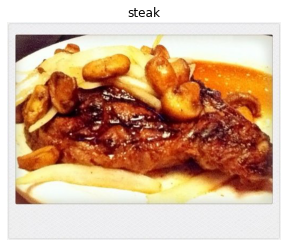

In [7]:
# Visualisons

image = view_random_image(
    target_dir="pizza_steak/train/",
    target_class="steak"
)

In [13]:
image.shape

(407, 512, 3)

## Workflow de Travail CNN de bout en bout


Found 1500 images belonging to 2 classes.
Found 500 images belonging to 2 classes.


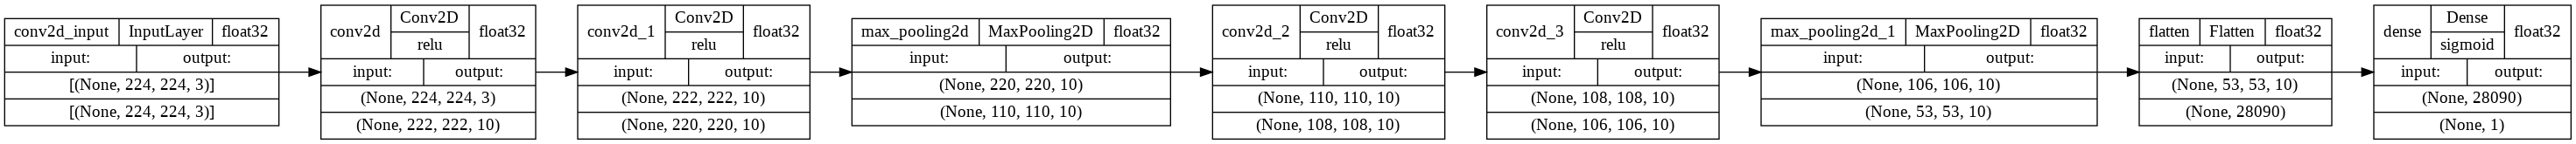

In [9]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Fixons la graine aléatoire
tf.random.set_seed(42)

# Prétraitement des images et Mise à l'échelle des pixels
# Instances du générateur de données d'images
train_datagen = ImageDataGenerator(rescale=1./255)
valid_datagen = ImageDataGenerator(rescale=1./255)

# Indiquons les chemins de nos répertoires de données
train_dir = "/content/pizza_steak/train"
test_dir = "/content/pizza_steak/test"

# Importons nos données depuis nos répertoires et mettons les dans des lots(batches)
train_data = train_datagen.flow_from_directory(
    directory=train_dir,
    batch_size=32,
    target_size=(224,224),
    class_mode="binary",
    seed=42
)

valid_data = valid_datagen.flow_from_directory(
    directory = test_dir,
    batch_size=32,
    target_size = (224, 224),
    class_mode="binary",
    seed=42
)

# Construisons notre modèle CNN
model_1 = tf.keras.Sequential([
    tf.keras.layers.Conv2D(
        filters=10,
        kernel_size=3,
        activation="relu",
        input_shape=(224, 224, 3)
    ),
    tf.keras.layers.Conv2D(
        10,
        3,
        activation="relu"
    ),

    tf.keras.layers.MaxPool2D(
        pool_size=2,
        padding="valid"
    ),

    tf.keras.layers.Conv2D(
        10,
        3,
        activation="relu"
    ),
    tf.keras.layers.Conv2D(
        10,
        3,
        activation="relu"
    ),
    
    tf.keras.layers.MaxPool2D(2),

    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(1, activation="sigmoid")
])

# Compilons notre modèle
model_1.compile(
    loss=tf.keras.losses.BinaryCrossentropy(),
    optimizer = tf.keras.optimizers.Adam(),
    metrics=["accuracy"]
)
# Architecture de notre modèle
tf.keras.utils.plot_model(model_1, to_file='model_1_cv_plot.png', show_shapes=True, show_layer_names=True, show_layer_activations=True, show_dtype=True, rankdir="LR",
                          expand_nested=False)

In [10]:
# Entrainons notre modèle
# Avantage de flow_from_directory => crée les étiquettes et les caractéristiques automatiquement
model_1_history = model_1.fit(
    train_data,
    epochs=5,
    steps_per_epoch=len(train_data),
    validation_data = valid_data,
    validation_steps = len(valid_data),
    verbose=1
)

Epoch 1/5
47/47 [==============================] - 25s 204ms/step - loss: 0.6198 - accuracy: 0.6473 - val_loss: 0.5191 - val_accuracy: 0.7300
Epoch 2/5
47/47 [==============================] - 9s 186ms/step - loss: 0.4499 - accuracy: 0.7940 - val_loss: 0.3648 - val_accuracy: 0.8420
Epoch 3/5
47/47 [==============================] - 9s 188ms/step - loss: 0.4130 - accuracy: 0.8153 - val_loss: 0.3319 - val_accuracy: 0.8520
Epoch 4/5
47/47 [==============================] - 9s 189ms/step - loss: 0.3743 - accuracy: 0.8347 - val_loss: 0.3420 - val_accuracy: 0.8480
Epoch 5/5
47/47 [==============================] - 9s 194ms/step - loss: 0.3387 - accuracy: 0.8647 - val_loss: 0.2970 - val_accuracy: 0.8860


In [11]:
model_1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 222, 222, 10)      280       
                                                                 
 conv2d_1 (Conv2D)           (None, 220, 220, 10)      910       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 110, 110, 10)     0         
 )                                                               
                                                                 
 conv2d_2 (Conv2D)           (None, 108, 108, 10)      910       
                                                                 
 conv2d_3 (Conv2D)           (None, 106, 106, 10)      910       
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 53, 53, 10)       0         
 2D)                                                    

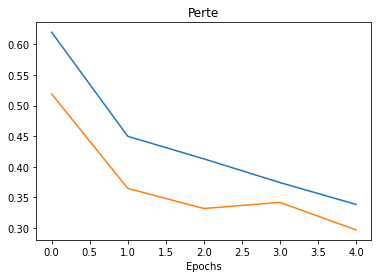

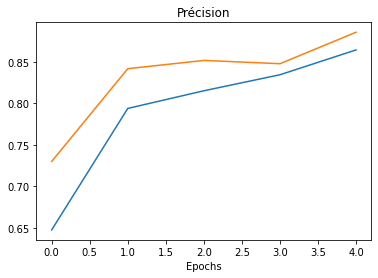

In [12]:
# Visualisons nos métriques sur le train et le validation set séparémment
def plot_metrics_curves(history):

  loss = history.history["loss"]
  val_loss = history.history["val_loss"]
  acc = history.history["accuracy"]
  val_acc= history.history["val_accuracy"]

  epochs = range(len(history.history["loss"]))

  
  # Visualisons les pertes
  plt.plot(epochs, loss, label='training_loss')
  plt.plot(epochs, val_loss, label='val_loss')
  plt.title('Perte')
  plt.xlabel('Epochs')

  # Visualisons les précisions 
  plt.figure()
  plt.plot(epochs, acc, label='training_accuracy')
  plt.plot(epochs, val_acc, label='val_accuracy')
  plt.title('Précision')
  plt.xlabel('Epochs')


plot_metrics_curves(model_1_history);

Found 1500 images belonging to 2 classes.
Found 500 images belonging to 2 classes.


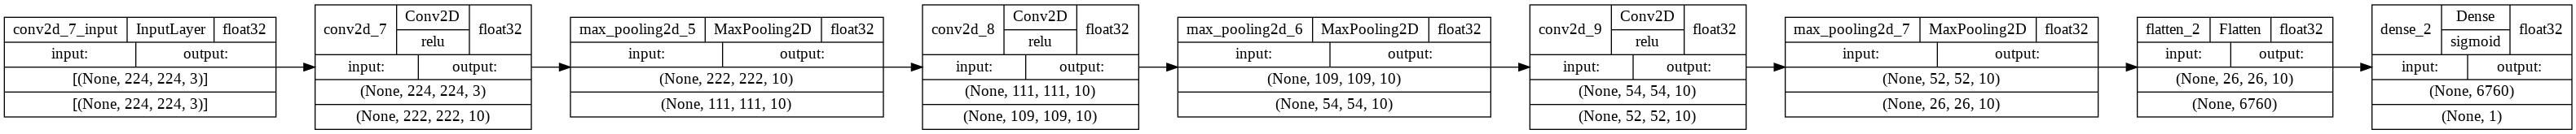

In [18]:
# Data Augmentation
train_datagen_augmented = ImageDataGenerator(
    rescale = 1/255.,
    rotation_range = 20,
    shear_range = 0.2,
    zoom_range = 0.2,
    width_shift_range = 0.2,
    height_shift_range = 0.2,
    horizontal_flip=True
)

train_data_augmented_shuffled = train_datagen_augmented.flow_from_directory(
    train_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode="binary",
    shuffle=True
)

test_datagen = ImageDataGenerator(rescale=1/255.)
test_data = test_datagen.flow_from_directory(test_dir,
                                             target_size=(224, 224),
                                             batch_size=32,
                                             class_mode='binary')



# Build the model
model_2 = tf.keras.Sequential([ 
    
    tf.keras.layers.Conv2D(
        filters=10,
        kernel_size = 3,
        strides = 1,
        padding="valid",
        activation="relu",
        input_shape = (224,224,3)
    ),
    tf.keras.layers.MaxPool2D(),

    tf.keras.layers.Conv2D(10,3,activation="relu"),
    tf.keras.layers.MaxPool2D(),
    tf.keras.layers.Conv2D(10,3,activation="relu"),
    tf.keras.layers.MaxPool2D(),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(1, activation="sigmoid")

])

# Compilons notre modèle
model_2.compile(
    loss=tf.keras.losses.BinaryCrossentropy(),
    optimizer = tf.keras.optimizers.Adam(),
    metrics=["accuracy"]
)
# Architecture de notre modèle
tf.keras.utils.plot_model(model_2, to_file='model_2_cv_plot.png', show_shapes=True, show_layer_names=True, show_layer_activations=True, show_dtype=True, rankdir="LR",
                          expand_nested=False)



In [20]:
model_2_history = model_2.fit(
    train_data_augmented_shuffled,
    epochs = 5,
    steps_per_epoch = len(train_data_augmented_shuffled),
    validation_data=test_data,
    validation_steps = len(test_data)
)

Epoch 1/5
47/47 [==============================] - 21s 457ms/step - loss: 0.6082 - accuracy: 0.6693 - val_loss: 0.4258 - val_accuracy: 0.8340
Epoch 2/5
47/47 [==============================] - 22s 468ms/step - loss: 0.5223 - accuracy: 0.7360 - val_loss: 0.3773 - val_accuracy: 0.8640
Epoch 3/5
47/47 [==============================] - 22s 462ms/step - loss: 0.4859 - accuracy: 0.7720 - val_loss: 0.3808 - val_accuracy: 0.8320
Epoch 4/5
47/47 [==============================] - 21s 454ms/step - loss: 0.4635 - accuracy: 0.7853 - val_loss: 0.3381 - val_accuracy: 0.8520
Epoch 5/5
47/47 [==============================] - 22s 462ms/step - loss: 0.4562 - accuracy: 0.7880 - val_loss: 0.3119 - val_accuracy: 0.8740


--2022-09-29 14:53:31--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/images/03-steak.jpeg
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1978213 (1.9M) [image/jpeg]
Saving to: ‘03-steak.jpeg’

03-steak.jpeg       100%[===================>]   1.89M  --.-KB/s    in 0.06s   

2022-09-29 14:53:31 (33.5 MB/s) - ‘03-steak.jpeg’ saved [1978213/1978213]



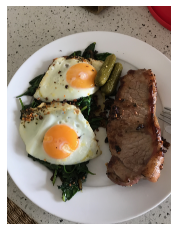

In [21]:
# Prédictions
# View our example image
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/images/03-steak.jpeg 
steak = mpimg.imread("03-steak.jpeg")
plt.imshow(steak)
plt.axis(False);

In [22]:
steak.shape

(4032, 3024, 3)

In [23]:
# Create a function to import an image and resize it to be able to be used with our model
def load_and_prep_image(filename, img_shape=224):
  """
  Reads an image from filename, turns it into a tensor
  and reshapes it to (img_shape, img_shape, colour_channel).
  """
  # Read in target file (an image)
  img = tf.io.read_file(filename)

  # Decode the read file into a tensor & ensure 3 colour channels 
  # (our model is trained on images with 3 colour channels and sometimes images have 4 colour channels)
  img = tf.image.decode_image(img, channels=3)

  # Resize the image (to the same size our model was trained on)
  img = tf.image.resize(img, size = [img_shape, img_shape])

  # Rescale the image (get all values between 0 and 1)
  img = img/255.
  return img

In [24]:
steak = load_and_prep_image("03-steak.jpeg")
steak

<tf.Tensor: shape=(224, 224, 3), dtype=float32, numpy=
array([[[0.6377451 , 0.6220588 , 0.57892156],
        [0.6504902 , 0.63186276, 0.5897059 ],
        [0.63186276, 0.60833335, 0.5612745 ],
        ...,
        [0.52156866, 0.05098039, 0.09019608],
        [0.49509802, 0.04215686, 0.07058824],
        [0.52843136, 0.07745098, 0.10490196]],

       [[0.6617647 , 0.6460784 , 0.6107843 ],
        [0.6387255 , 0.6230392 , 0.57598037],
        [0.65588236, 0.63235295, 0.5852941 ],
        ...,
        [0.5352941 , 0.06862745, 0.09215686],
        [0.529902  , 0.05931373, 0.09460784],
        [0.5142157 , 0.05539216, 0.08676471]],

       [[0.6519608 , 0.6362745 , 0.5892157 ],
        [0.6392157 , 0.6137255 , 0.56764704],
        [0.65637255, 0.6269608 , 0.5828431 ],
        ...,
        [0.53137255, 0.06470589, 0.08039216],
        [0.527451  , 0.06862745, 0.1       ],
        [0.52254903, 0.05196078, 0.0872549 ]],

       ...,

       [[0.49313724, 0.42745098, 0.31029412],
        [0.05

In [27]:
model_1.predict(steak)

ValueError: ignored

In [28]:
print(f"Shape before new dimension: {steak.shape}")
steak = tf.expand_dims(steak, axis=0) # add an extra dimension at axis 0
#steak = steak[tf.newaxis, ...] # alternative to the above, '...' is short for 'every other dimension'
print(f"Shape after new dimension: {steak.shape}")
steak


Shape before new dimension: (224, 224, 3)
Shape after new dimension: (1, 224, 224, 3)


<tf.Tensor: shape=(1, 224, 224, 3), dtype=float32, numpy=
array([[[[0.6377451 , 0.6220588 , 0.57892156],
         [0.6504902 , 0.63186276, 0.5897059 ],
         [0.63186276, 0.60833335, 0.5612745 ],
         ...,
         [0.52156866, 0.05098039, 0.09019608],
         [0.49509802, 0.04215686, 0.07058824],
         [0.52843136, 0.07745098, 0.10490196]],

        [[0.6617647 , 0.6460784 , 0.6107843 ],
         [0.6387255 , 0.6230392 , 0.57598037],
         [0.65588236, 0.63235295, 0.5852941 ],
         ...,
         [0.5352941 , 0.06862745, 0.09215686],
         [0.529902  , 0.05931373, 0.09460784],
         [0.5142157 , 0.05539216, 0.08676471]],

        [[0.6519608 , 0.6362745 , 0.5892157 ],
         [0.6392157 , 0.6137255 , 0.56764704],
         [0.65637255, 0.6269608 , 0.5828431 ],
         ...,
         [0.53137255, 0.06470589, 0.08039216],
         [0.527451  , 0.06862745, 0.1       ],
         [0.52254903, 0.05196078, 0.0872549 ]],

        ...,

        [[0.49313724, 0.42745098, 

In [32]:
pred = model_1.predict(steak)
pred

array([[0.9508027]], dtype=float32)

In [33]:
class_names

array(['pizza', 'steak'], dtype='<U5')

In [34]:
pred_class = class_names[int(tf.round(pred)[0][0])]
pred_class

'steak'

In [35]:
def pred_and_plot(model, filename, class_names):
  """
  Imports an image located at filename, makes a prediction on it with
  a trained model and plots the image with the predicted class as the title.
  """
  # Import the target image and preprocess it
  img = load_and_prep_image(filename)

  # Make a prediction
  pred = model.predict(tf.expand_dims(img, axis=0))

  # Get the predicted class
  pred_class = class_names[int(tf.round(pred)[0][0])]

  # Plot the image and predicted class
  plt.imshow(img)
  plt.title(f"Prediction: {pred_class}")
  plt.axis(False);


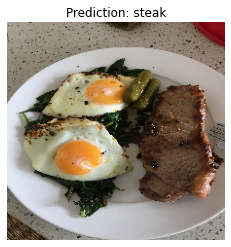

In [38]:
pred_and_plot(model_1, "03-steak.jpeg", class_names)